# Motivation 

I have three primary motivations with this notebook:

1) to stimulate ideas for using more conventional, content-expertise-based models in more effective and innovative ways, so to bypass (or at least reduce the extent of reliance upon) models with low interpretability. 

2) to generate parallel and contrastive supplements to 'black-box' models with high accuracy rates, so to better understand *what* those models are picking-up on in generating their functions, the extent to which those things are consistent with our intuitions and expectations, and to explore where -- and why -- the models' methods and our guesses diverge.

3) to provide, in tandem with the above, a suite of quantitative measures to inform how we can better use a model of any kind to provide more accurate, learner-accessible feedback in targeted ways. 

# Side note on lesser-used libraries

Kaggle kernels include popular Python modules, like Pandas, Sklearn, and Numpy. From what I've experienced, the heavyweight modules in NLP -- Spacy, NLTK, HuggingFace, Gensim, etc. -- all seem to be available and fully functional.  

Others, however, aren't available without manually uploading them. The process for this is described in [this](https://www.kaggle.com/code/samuelepino/pip-downloading-packages-to-your-local-machine/notebook?scriptVersionId=29576961) discussion, and I've circumvented this process in this notebook, by simply leaving the internet enabled. For this competition -- as well as many others-- however, internet must be disabled, and so you'll have to implement the instructions above. Once you've gotten that all sorted, you'll use a command like: 

> ! pip install textstat --no-index --find-links=file:///kaggle/input/textstat071py3/

The modules I've had trouble with that are included in this project are: 
- [textstat](https://pypi.org/project/textstat/)
- [pyphen](https://pypi.org/project/pyphen/)
- [contractions](https://pypi.org/project/contractions/)
- [language-tool-python](https://pypi.org/project/language-tool-python/)
- [texthero](https://texthero.org/)

And I can't recall exactly what all I've had to do before regarding NLTK corpora, as well as the reference data needed for [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/), [textblob](https://textblob.readthedocs.io/en/dev/), [spellchecker](https://pyspellchecker.readthedocs.io/en/latest/), and maybe some others. If you run into trouble, however, the same process should work for all except textstat and language-tool-python. For some reason (which may well be my ignorance) I can't get the language-tool-python request to work, so if you get that one figured out, comment! TextHero is functional, though many warnings accompanied my install command, having to do apparently with version incompatibility issues with spacy and the kernel. As with LTP, any insights, tricks, or experiences are eagerly welcomed.

# General Cleaning and Preprocessing

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None
import pprint
pp = pprint.PrettyPrinter(indent=2)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import os

train = pd.read_csv('train.csv')
train.head(5)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
train['full_text'][2]

"Dear, Principal\n\nIf u change the school policy of having a grade b average that unfair. Because many students have a C average. So that means that they cant go out for sports or other activities they want to do bad. That's like taking everything they have. What if kids want to become good at something, but now they cant because of that school policy. If they have a C average they should still be able to go out for sports or activities. A C average isn't that bad, its higher then a D average. If the school police was if you have a D average of lower they shouldn't do sports or activities. If they have a D average in school for not working hard, that's means that they in ain't going to try hard. If they have a C average and there trying hard they should be able to out for sports or activities. What if all the good people in sports have a C average in school, that means that they cant play and were going to lose every game we have. That's a good policy to get grade's up but don't take 

In [7]:
#Since there are some issues visible regarding formatting/encoding, I'll clean that out before proceeding. 

import regex as re
import string
import gensim
from gensim.parsing.preprocessing import strip_multiple_whitespaces


def encoding_cleaning_ascii(x):
    return x.encode(encoding = 'ascii', errors = 'ignore').decode()
def encoding_cleaning_utf8(x):
    return x.encode(encoding = 'utf-8', errors = 'ignore').decode()
def encoding_cleaning_cp1252(x):
    return x.encode(encoding = 'cp1252', errors = 'ignore').decode()
def encoding_cleaning_all(x):
    x = encoding_cleaning_ascii(x)
    x = encoding_cleaning_utf8(x)
    x = encoding_cleaning_cp1252(x)
    return x
def general_cleaning(x):
    text = str(x)
    text = encoding_cleaning_all(text)
    text = text.strip()
    text = strip_multiple_whitespaces(text)
    text = re.sub(r"\n", "", text)
    return text

In [8]:
train['Full_Text'] = train['full_text'].apply(general_cleaning)
train['Given_Character_Count'] = train['Full_Text'].apply(lambda x: len(x))
train['Given_Word_Count'] = train['Full_Text'].apply(lambda x: len([i for i in x.split()]))

In [9]:
#For some coming topics, I'll want the text in its original format, in others, I'll need more conventionally processed text.

import contractions
contractions.add("i'm", 'i am')
def fix_contractions(x):
    return contractions.fix(x)

#Super-Easy cleaning with TextHero, though challenges RE Kaggle kernels and customizability. 
import texthero as hero
from texthero import preprocessing
txt_cleaning_pipe = [preprocessing.fillna,
                    preprocessing.lowercase,
                    preprocessing.remove_digits,
                    preprocessing.remove_punctuation,
                    preprocessing.remove_diacritics,
                    preprocessing.remove_whitespace]

In [10]:
train['Full_Text_Cleaned'] = train['Full_Text'].apply(contractions.fix)
train['Full_Text_Cleaned'] = hero.clean(train['Full_Text_Cleaned'], pipeline = txt_cleaning_pipe)

#  Summary DV

So, despite this competition featuring multiple outputs, it strikes me as odd to EDA by iterating across all of them. And it's not as though the DVs are independent of one another. As we can see below, they are in fact highly correlated, which is very intuitive. I think this may be amenable to a stack of some kind, or perhaps a Regressor Chain, to capture the fact that scoring well in one category predicts scoring well in the next. For now, though, I want to create a single, summary DV that is just a sum of all the independent scores. Since they are so strongly correlated, I don't think this will throw off anything in terms of EDA/feature-engineering/mining, and it will make regression analysis much easier.

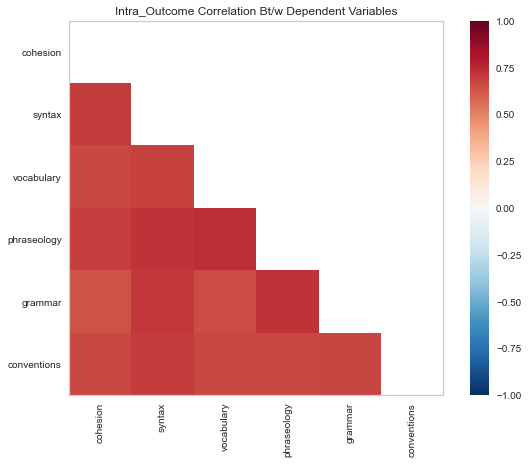

In [11]:
y = train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']]

from yellowbrick.features import Rank2D

visualizer1 = Rank2D(algorithm = 'pearson', 
                    size = (696,496),
                    title = 'Intra_Outcome Correlation Bt/w Dependent Variables')

visualizer1.fit_transform(train[[i for i in y]])
visualizer1.show();

In [12]:
train['Summary_DV'] = train[['cohesion', 'syntax', 'grammar', 'phraseology', 'vocabulary', 'conventions']].sum(axis =1)

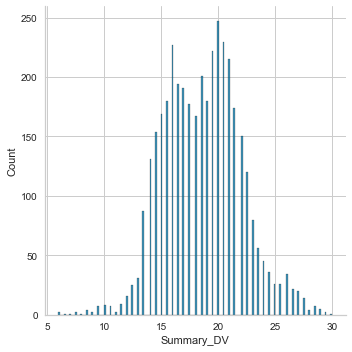

In [13]:
import seaborn as sns
sns.displot(train, x = 'Summary_DV', bins = 150);  

While a little bit hard on the eyes, the following graphic shows just how normal and linearly related these features all are -- a wall of straight lines, and a Gaussian curves. By inference, a model effectively predicting one (or a composite) will be predictive of the remainder, but make the analysis much simpler, and may be amenable to a stacking ensemble. 

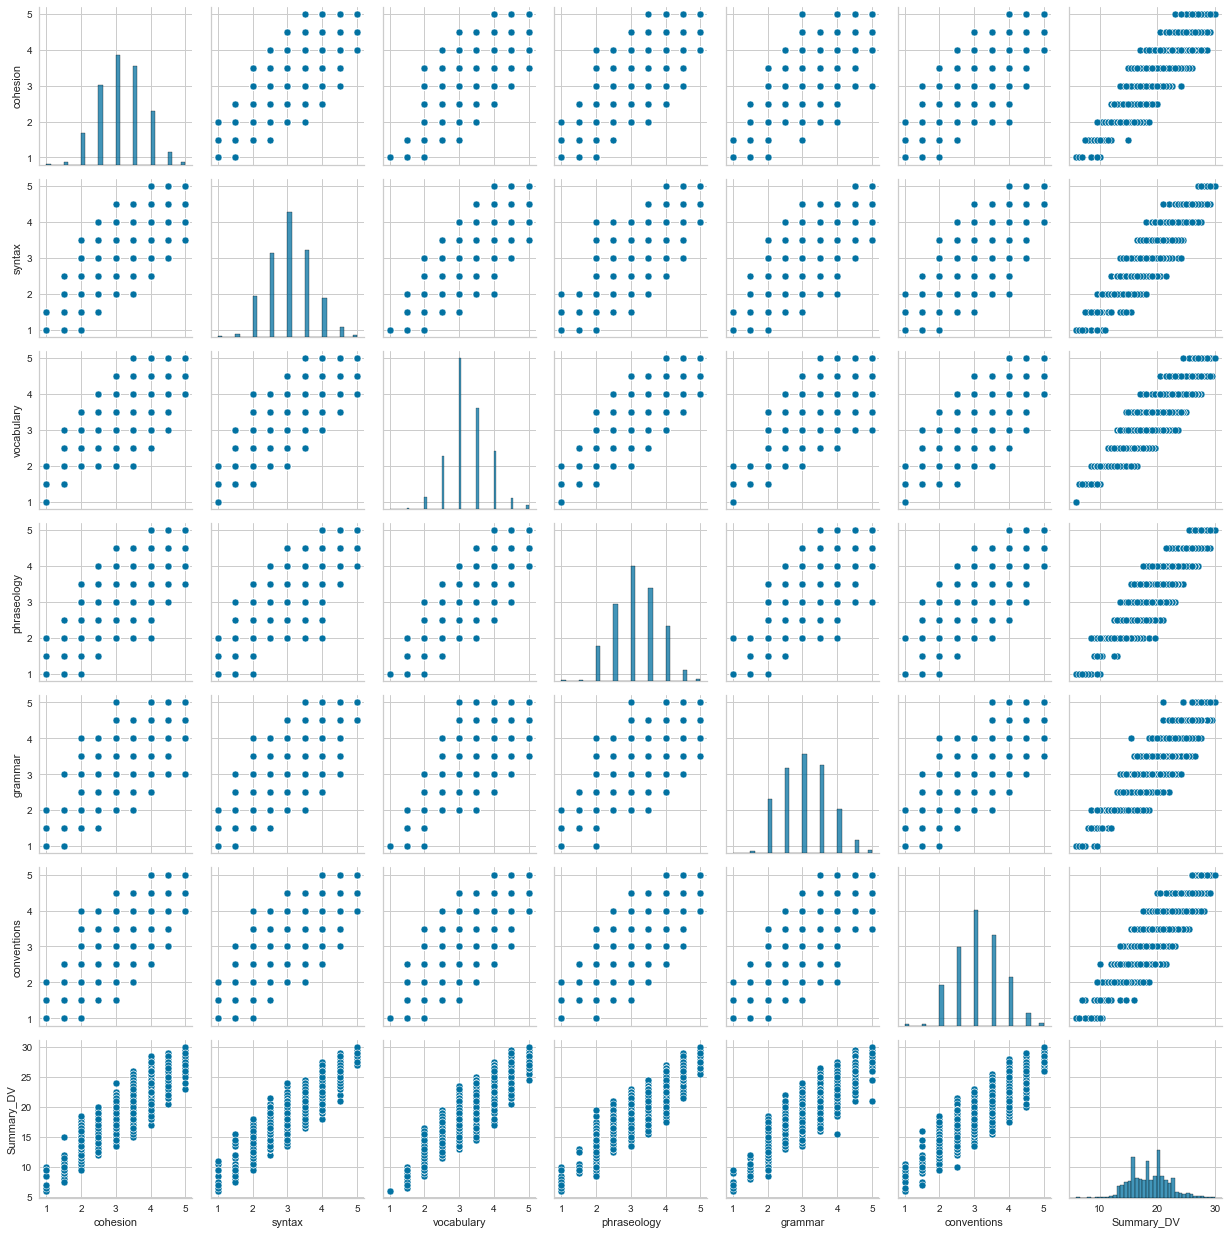

In [15]:
y = train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'Summary_DV']]

detailed = sns.PairGrid(y)
detailed.map_diag(sns.histplot)
detailed.map_offdiag(sns.scatterplot);

# Variations on text representation

In [16]:
#Tokenization: with and without stopword removal
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

from gensim.parsing.preprocessing import remove_stopwords
gensim_stop_words = [i for i in set(gensim.parsing.preprocessing.STOPWORDS)]
gensim_stop_words += ['like', 'the', 'want', 'i','anybody', 'guys', 'basically', 'conclusion','very', 'whatever']

train['Text_Tokens_Minus_SW'] = train['Full_Text_Cleaned'].apply(lambda x: [i for i in tokenizer.tokenize(x)\
                                                                            if i not in gensim_stop_words])

train['Text_Tokens_Full_Text'] = train['Full_Text_Cleaned'].apply(lambda x: tokenizer.tokenize(x))

In [17]:
#Strings of stopword-cleared and non-stopword-cleared tokens:
train['Token_Strings'] = train['Text_Tokens_Minus_SW'].apply(lambda x: ' '.join([i for i in x if len(i) > 1]))
train['Token_Strings_Full_Text'] = train['Text_Tokens_Full_Text'].apply(lambda x: ' '.join([i for i in x]))

In [18]:
#Sentence Tokens
from nltk.tokenize import sent_tokenize
train['Token_Sentences'] = train['Full_Text'].apply(sent_tokenize)

In [19]:
#List of textblobs
from textblob import TextBlob
from textblob import Word

def blobs(sentence_list):
    bloblist = []
    for sentence in sentence_list:
        sent_prime = TextBlob(sentence)
        bloblist.append(sent_prime)
        
    return bloblist

train['Blobs'] = train['Token_Sentences'].apply(blobs)

In [ ]:
#Lemmatized text
from nltk import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for token_list in train['Text_Tokens_Minus_SW']:
    for token in token_list: 
        lemmatizer.lemmatize(token)

# Feature Engineering

# 1: TextStat
A lot of useful features can be generated with this module, saving you (and I!) the trouble of working them out. I've chosen a small subset here, but many alternatives could have been used, as preference or need dictates. 

In [ ]:
import textstat
from tqdm import tqdm

train['Reading_Time'] = 0
train['Average_Char_per_Word'] = 0
train['Reading_Ease'] = 0
train['Average_Sen_Length'] = 0
train['Average_Syllables_per_Word'] = 0
train['Word_Count'] = 0
train['Text_Grade_Consensus'] = None

for i in tqdm(range(len(train))):
    train['Average_Char_per_Word'][i] = textstat.avg_character_per_word(train['Token_Strings'][i])
    train['Average_Syllables_per_Word'][i] = textstat.avg_syllables_per_word(train['Token_Strings'][i])
    train['Reading_Ease'][i] = textstat.flesch_reading_ease(train['Token_Strings'][i])
    train['Word_Count'][i] = textstat.lexicon_count(train['Token_Strings'][i])    
    train['Average_Sen_Length'][i] = textstat.avg_sentence_length(train['Full_Text'][i])
    train['Reading_Time'][i] = textstat.reading_time(train['Full_Text'][i])
    train['Text_Grade_Consensus'][i] = textstat.text_standard(train['Token_Strings'][i])   
    
train['Text_Grade_Consensus'] = train['Text_Grade_Consensus'].astype('category').cat.codes

##### 2: Sentiment Intensity Analyzer

I'm not confident it will be useful, but that's what we are here to find out! Tip o' the Hat to [MSalam](https://www.kaggle.com/code/mdshahbazalam/lgbm-multioutputregressor) for this very tidy little loop. 

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def generate_sentiment_scores(data):
    SID = SentimentIntensityAnalyzer()
    Negative_Sentiment=[]
    Positive_Sentiment=[]
    Neutral_Sentiment=[]
    Compound_Sentiment=[]
    for sentence in tqdm(data['Full_Text_Cleaned'].values): 
        sentence_sentiment_score = SID.polarity_scores(sentence)
        Compound_Sentiment.append(sentence_sentiment_score['compound'])
        Negative_Sentiment.append(sentence_sentiment_score['neg'])
        Positive_Sentiment.append(sentence_sentiment_score['pos'])
        Neutral_Sentiment.append(sentence_sentiment_score['neu'])
    return Compound_Sentiment, Negative_Sentiment, Positive_Sentiment, Neutral_Sentiment

train['Compound_Sentiment'], train['Negative_Sentiment'], train['Positive_Sentiment'],\
train['Neutral_Sentiment'] = generate_sentiment_scores(train)

##### 3: Spelling

There are quite a few modules that support spellcheck and related functions, and I've gotten mixed results. For that reason, we can take a few distinct approaches, then perhaps summarize the scores as a single output in addition to the individual scores.

In [ ]:
#The first approach simply samples the top-N (here, ~25/top 100) most frequently misspelled words in English:

Misspells = ['absense', 'adress', 'alot', 'beleive', 'cieling', 'calendur', 'begining', 'experiance', 'embarass', 'sience', 
            'seperate', 'wierd', 'truely', 'independant', 'goverment', 'hieght', 'foriegn', 'greatful', 'enviroment', 
             'privelege' 'libary', 'lisense', 'misterious', 'neccessary', 'peice', 'nieghbor', 'peolpe', 'electorals', 'stuf', 
             'alot', 'stuff', 'think', 'whats', 'pharaoh', 'activitys','ther', 'gonna', 'beacause', 
             'actaully', 'somone', 'selves', 'driveing', 'paragragh', 'moc', 'aswell']

#Likewise, since the use of incorrectly punctuated contractions is a form of common and predictable misspelling: 

Bad_Contractions = ['cant', 'wont', 'isnt', 'aint', 'dont', 'werent', 'wernt', 'doesnt', 'thats', 'arent', 'couldnt',
                   'wouldnt', 'didnt', 'hadnt', 'Im', 'im', 'shouldnt', 'shes', 'hes', 'lets', 'id', 'hed', 'havent', 'ill',
                   'ive', 'Ive', 'Ill', 'theres', 'theyd', 'theyre', 'theyll', 'weve', 'wed', 'youve', 'youre', 'youd',
                    'whos', 'whove', 'wheres', 'whats']

Misspelled_List = Misspells + Bad_Contractions

def Listed_Spelling(token_lst):
    return len([i for i in token_lst if i in Misspelled_List])

train['Errors_Spelling'] = train['Text_Tokens_Minus_SW'].apply(Listed_Spelling)

In [ ]:
#One use of the SpellChecker module.
from spellchecker import SpellChecker
spellchkr = SpellChecker()

train['Checker_Spelling'] = train['Token_Strings'].apply(lambda x: spellchkr.unknown([i for i in x.split()]))
train['Checker_Spelling'] = train['Checker_Spelling'].apply(lambda x: [i for i in x if i not in Bad_Contractions])
train['Count_Checker_Spelling'] = train['Checker_Spelling'].apply(lambda x: len([i for i in x]))

In [ ]:
#Scoring closeness of misspelled word to proposed correction
train['Fuzz_Blobs'] = train['Checker_Spelling'].apply(lambda x: [TextBlob(i) for i in x])

from textblob import Word
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def Fuzz_Test(blobs):
    alpha = len(blobs)
    if alpha == 0:
        return 0
    else:
        fuzz_score = 0
        for token in blobs:
                NewToken = spellchkr.correction(token)
                fuzz_score+= fuzz.ratio(token, NewToken)
        mean_fuzz = fuzz_score/alpha
        norm_fuzz = 100 - mean_fuzz
    return norm_fuzz

train['Fuzz_Blobs'] = train['Fuzz_Blobs'].apply(lambda x: [Fuzz_Test(i) for i in x])

#To normalize across features, and adjust for those features with no misspellings, etc.

def Blob_Score_Norm(x):
    total = 0.1
    for i in x:
        total+=i
    return total

train['Fuzz_Blobs'] = train['Fuzz_Blobs'].apply(Blob_Score_Norm)

for i in range(len(train)):
    if train['Count_Checker_Spelling'][i] != 0:
        train['Fuzz_Blobs'][i] = round((train['Fuzz_Blobs'][i])/(train['Count_Checker_Spelling'][i]), 2)

###### 4: Punctuation Usage

In [ ]:
#Usage at all
punctuation_marks = list(string.punctuation)
train['Punctuation_Usage'] = train['Full_Text'].apply(lambda x: len([i for i in x if i in punctuation_marks]))

In [ ]:
#More specific counts
train['Exclamations'] = 0 
train['Quotations'] = 0
train['Punctuation_Diversity'] = 0 
train['Periods'] = 0
train['Capitals'] = 0
train['NumericalCharacters'] = 0

for i in range(len(train)):
    Exclamations = 0
    Quotation_Marks = 0
    Punctuation_Diversity = 0
    Periods = 0
    Capitals = 0
    NumericalCharacters = 0
    for char in train['full_text'][i]:
        if char == '!':
            Exclamations+=1
        elif char == '"':
            Quotation_Marks+=1
        elif char == '.':
            Periods+=1
        elif char.isupper():
            Capitals+= 1
        elif char.isdigit():
            NumericalCharacters+=1

    mark_set = set([char for char in train['full_text'][i]])
    Punctuation_Diversity+= len(mark_set)
    train['Exclamations'][i]+= Exclamations
    train['Quotations'][i]+= Quotation_Marks
    train['Punctuation_Diversity'][i] = Punctuation_Diversity
    train['Periods'][i]+= Periods 
    train['Capitals'][i]+= Capitals
    train['NumericalCharacters'][i]+= NumericalCharacters

In [ ]:
#Convention requires at least 1 upper-case letter for each period that occurs in the text (with margin of error for ellipses)
train['Capital_to_Period_Ratio'] = 0
for i in range(len(train)):
    Capitals = train['Capitals'][i]
    Periods = train['Periods'][i]
    c2p = 0
    if Capitals != 0 and Periods != 0: 
        c2p+= Capitals/Periods
    else:
        continue
        
    train['Capital_to_Period_Ratio'][i]+= c2p

##### 5: Vocabulary and Lexical Analysis

In [ ]:
train['Polysyllable_Count'] = train['full_text'].apply(lambda x: textstat.polysyllabcount(x))
train['Monosyllable_Count'] = train['full_text'].apply(lambda x: textstat.monosyllabcount(x))
train['Lexical_Diversity'] = train['text_tokens_minus_sw'].apply(lambda x: len(set(x)))

In [ ]:
#Analysis of word-frequency, used to indicate simple textual cohesion
from nltk.probability import FreqDist
document_corpus = ' '.join([word for word in train['Token_Strings']])
corpus_tokens = tokenizer.tokenize(document_corpus)
fdist = FreqDist(corpus_tokens)

topical_n_grams = fdist.most_common(150)
topical_n_grams_list = []
for tupe in topical_n_grams:
    topical_n_grams_list.append(tupe[0])
topical_n_grams_minus_stopwords = [i for i in topical_n_grams_list if i not in gensim_stop_words]

train['Topical_Tokens'] = train['Text_Tokens_Minus_SW'].apply(lambda x:\
                                                                  len([i for i in x if i in topical_n_grams_minus_stopwords]))

In [ ]:
#Roughly looking for contributions that are neither stopwords nor highly frequent corpus-derived words
informative_dist = [i for i in fdist if i not in gensim_stop_words]

informative_dist_to_discard = informative_dist[0:100]
train['Distinctive_Tokens'] = train['Text_Tokens_Minus_SW'].apply(lambda x:\
                                                                  [i for i in x if i not in informative_dist_to_discard])

In [ ]:
#Similar to above, but the NLTK corpus stop-words are a bit less restrictive than the list from gensim.
from nltk.corpus import stopwords
nltk_stop_words = stopwords = nltk.corpus.stopwords.words('english')

def content_fraction(text):
    content = [w for w in text if w not in nltk_stop_words]
    return len(content) / len(text)

train['Stopword_Proportion'] = 0
for i in range(len(train)):
    train['Stopword_Proportion'][i] = content_fraction(train['Text_Tokens_Full_Text'][i])

In [ ]:
'''From the previous Kaggle Feedback Prize (Predicting Effective Arguments). The unigrams and bigrams are uniquely from essays 
in that competition which scored 'Effective,' stripped of stopwords and topical n-grams.'''

import pickle as pkl

complex_unigrams= ['procrastinate', 'whereas', 'detrimental', 'grasp', 'pursue', 'additionally', 'irrelevant', 'critical',
          'motivation', 'thus', 'however', 'assignments', 'assignment', 'source', 'sources', 'interests', 'asking', 'given',
          'skills', 'education', 'educational', 'ability', 'schooling', 'beneficial', 'allowing', 'instance', 'example',
            'therefore', 'excel', 'concepts', 'perspective', 'contradictory', 'allows', 'solutions', 'direction','forgoing',
            'view', 'viewpoint', 'confirmatory', 'confirm', 'evidence', 'proof', 'disprove', 'prove', 'contradict',
            'challenge', 'challenging', 'contradict', 'mislead', 'demonstrate', 'misleading', 'compromise', 'resolve']

def complexity_eff(token_lst):
    score = 0
    for item in token_lst:
        if item in complex_unigrams:
            score +=1
            
    return score

train['Complex_Unigrams'] = train['Text_Tokens_Minus_SW'].apply(lambda x: complexity_eff(x))

zeta = open('zeta2', 'rb')
db = pkl.load(zeta)
zetanew = db.copy()
zeta.close()

theta = open('theta2', 'rb')
db2 = pkl.load(theta)
thetanew = db2.copy()
theta.close()

def bigram_use(text):
    score = 0
    for bg in list(nltk.bigrams(text)):
        if bg in zetanew:
            score +=2
        if bg in thetanew:
            score +=1
            
    return score

train['Complex_Bigrams'] = train['Text_Tokens_Minus_SW'].apply(bigram_use)

In [ ]:
#Miscellaneous metrics
ad_hominemlist = ['idiot', 'stupid', 'dumb', 'loser', 'losers', 'idiots', 'morons', 'moron', 'liar', 'liars']
train['Ad_Hominem_Count'] = train['text_tokens_minus_sw'].apply(lambda x: len([i for i in x if i in ad_hominemlist]))

pronouns = ['he', 'she', 'they', 'them', 'i', 'her', 'him', 'it', 'we', 'you', 'us']
conjunctive_list = ['for', 'and', 'nor', 'but', 'or', 'yet', 'so']
indexicals = ['it', 'that', 'which', 'this']

pronoun_index_comb = pronouns + indexicals

def p_i_diversity_f(text):
    score = 0
    unique_words = set([i for i in text])
    for i in unique_words: 
        if i in pronoun_index_comb:
            score+=1
        
    return score

train['Conjunction_Count'] = train['Text_Tokens_Full_Text'].apply(lambda x: len([i for i in x if i in conjunctive_list]))
train['Pronoun_Count'] = train['Text_Tokens_Full_Text'].apply(lambda x: len([i for i in x if i in pronouns]))
train['Indexical_Count'] = train['Text_Tokens_Full_Text'].apply(lambda x: len([i for i in x if i in pronouns]))
train['P_I_Diversity'] = train['Text_Tokens_Full_Text'].apply(p_i_diversity_f)

###### 6: Redundancy and Sentential 'Entropy'
Vis-a-vis C. Shannon and the related Information Theoretical ideas regarding predictability, surprise, and original contribution.

The modules referenced can be found here: 
- [pronouncing](https://pypi.org/project/pronouncing/) 
- [lingua](https://pypi.org/project/lingua/)
- [pyenchant](https://pypi.org/project/pyenchant/)

In [ ]:
train['Text_Tokens_Two'] = train['Text_Tokens_Full_Text'].apply(lambda x: [i for i in x if i not in gensim_stop_words])

train['Informative_Proportion_One'] = 0

for i in range(len(train)):
    train['Informative_Proportion_One'][i] = len(train['Text_Tokens_Two'][i])/len(train['Text_Tokens_Full_Text'][i])


train['Informative_Proportion_Two'] = 0

for i in range(len(train)): 
    train['Informative_Proportion_Two'][i] = len(train['Distinctive_Tokens'][i])/len(train['Text_Tokens_Full_Text'][i])

In [ ]:
import pronouncing

def syllables_and_gibberish(x):
    pronunciation_list = []
    for i in x: 
        syl = pronouncing.phones_for_word(i)
        try:
            syllab_count = pronouncing.syllable_count(syl[0])
            pronunciation_list.append(syllab_count)
        except:
            continue
    return len(pronunciation_list)

train['S_And_G'] = train['Text_Tokens_Minus_SW'].apply(syllables_and_gibberish)
train['S_And_G_Score'] = train['Word_Count']-train['S_And_G']

In [ ]:
from lingua import Language, LanguageDetectorBuilder
languages = [Language.ENGLISH, Language.SPANISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()
def is_spanish(tokenlist):
    score = 0
    for token in tokenlist:
        alpha = detector.detect_language_of(token)
        if alpha == Language.SPANISH:
            score+=1
        else:
            continue
    return score
train['Is_Spanish'] = train['Distinctive_Tokens'].apply(is_spanish)

Reference for [letter-frequency.](https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html)

In [ ]:
#Analyzing letter frequency against P(X=x)| general language usage.

#Enchant is a spelling dictionary and spell-checker
import enchant
d = enchant.Dict('en_US')

from gensim.parsing.preprocessing import strip_punctuation

most_common_letters = ['e', 'a', 'o', 't', 'n']
least_common_letters = ['z', 'x', 'v', 'q', 'k', 'j']

def letter_probability(tokenSentenceList):
    
    redundant_letter_count = 0
    surprising_letter_correct_usage = 0

    for sentence in tokenSentenceList:
        for letter in sentence:
            if letter in most_common_letters:
                redundant_letter_count += 1
        for word in sentence.split():
            for m in least_common_letters:
                if m in word:
                    word = strip_punctuation(word)
                    if d.check(word):
                        surprising_letter_correct_usage+=1
                        
    return redundant_letter_count, surprising_letter_correct_usage

train['Redundant_Letters'] = None
train['Surprising_Letters'] = None
for i in range(len(train)):
    train['Redundant_Letters'][i], train['Surprising_Letters'][i] = letter_probability(train['token_sentences'][i])
    
train['Redundant_Char_Proportion'] = train['Redundant_Letters']/train['Given_Character_Count']
train['Surprising_Char_Usage'] = train['Surprising_Letters']/train['Given_Word_Count']

###### 7: Subject Verb Agreement

A frequent form of grammatical error for any second-language learner -- and one that isn't nearly as represented amongst native speakers, irrespective of formal education -- is the mismatching of subject and verb, especially in more complex conjugations, moods, and tenses. The very simple loops below can be mixed-and-matched to capture some of the most common phrases and combinations. 

In [ ]:
#Pronouns by verb-conjugation-group:
group_i = 'i'
group_1 = ['i', 'we', 'they']
group_2 = ['he', 'she', 'it']
group_plural = ['we', 'they']
all_pronouns = ['i', 'she', 'he', 'it', 'they', 'we']

#To have
group_1_have = 'have'
group_2_have = 'has'

#Present_Continuous/Simple
group1_present = ['have', 'do', 'say', 'make', 'go', 'take', 'come', 'see', 'get', 'think', 'feel', 'want']
group2_present = ['has', 'does', 'says', 'makes', 'goes', 'takes', 'comes', 'sees', 'gets', 'thinks', 'feels', 'wants']

#To be
group_i_be_form = ['am', 'was']
group_2_be_form = ['is', 'was']
group_plural_be_form = ['are','were']

#Modals
modals = ['could', 'would', 'should']
modal_thirds = ['be', 'have', 'do', 'say', 'make', 'go', 'take', 'come', 'see', 'get', 'think', 'feel', 'want']
modal_fourths = ['been', 'had', 'done']

ppp_have = ['having', 'has', 'have']
ppp_else = ['had', 'been', 'done', 'said', 'made', 'gone', 'taken', 'seen']

gen_misuse = ['maked', 'goed', 'taked', 'tooken', 'comed', 'getted', 'doed', 'maken', 'peoples']

In [ ]:
def sva_generalERR(x):
    word_list= x.split()
    gen_v_misuse = 0
    for i in range(len(word_list)):
        if word_list[i] in gen_misuse:
            gen_v_misuse+=1
            
    return gen_v_misuse

def sva_they_sERR(x):
    
    theyscore = 0
    theywords = x.split()
    
    for idx in range(len(theywords)-2):
        if theywords[idx] in ['they', 'will']:
            if theywords[idx+1].endswith('s'):
                if theywords[idx+1] != 'always':
                    theyscore+=1
                
    return theyscore

def sva_past_perfect_participle(x):
    word_list= x.split()
    past_done = 0
    for i in range(len(word_list)-2):
        if word_list[i] in ppp_have:
            if word_list[i+1] in ppp_else:
                past_done+=1
    
    return past_done    

def sva_past_ToDo(x):
    word_list= x.split()
    past_done2 = 0
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'done':
                past_done2+=1
                
    return past_done2

def sva_simple(x):
    word_list = x.split()
    simple_present = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_1:
            if word_list[i+1] in group1_present:
                simple_present+= 1
        
        if word_list[i] in group_2:
            if word_list[i+1] in group2_present:
                simple_present+=1
                
    return simple_present

def sva_simpleERR(x):
    word_list = x.split()
    simple_ERR = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_1:
            if word_list[i+1] in group2_present:
                simple_ERR+= 1
        
        if word_list[i] in group_2:
            if word_list[i+1] in group1_present:
                simple_ERR+=1
                
    return simple_ERR

def sva_future(x):
    
    word_list = x.split()
    sva_future = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'will':
                if word_list[i+2] in group1_present:
                    sva_future+=1
            
    return sva_future

def sva_futureERR(x):
    
    word_list = x.split()
    sva_futureERR = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'will':
                if word_list[i+2] in group2_present:
                    sva_futureERR+=1
            
    return sva_futureERR

def sva_ToBe(x):
    word_list = x.split()
    simple_to_be = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_i:
            if word_list[i+1] in group_i_be_form:
                simple_to_be+= 1
                
        if word_list[i] in group_plural:
            if word_list[i+1] in group_plural_be_form:
                simple_to_be+=1
        
        if word_list[i] in group_2:
            if word_list[i+1] in group_2_be_form:
                simple_to_be+=1
                
    return simple_to_be


def sva_ToBeERR(x):
    word_list = x.split()
    simple_to_beERR = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_i:   # = i
            if word_list[i+1] == 'is' or word_list[i+1] in group_plural_be_form:   #group_plural_be_form = ['are','were']
                simple_to_beERR+= 1
                #
        if word_list[i] in group_plural: #we/they
            if word_list[i+1] in group_i_be_form or word_list[i+1] in group_2_be_form:  #am/is/was
                simple_to_beERR+=1
        #
        if word_list[i] in group_2: #he/she/it 
            if word_list[i+1] == 'am' or word_list[i+1] in group_plural_be_form: #am/are/wer
                simple_to_beERR+=1
                
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'be':
                simple_to_beERR+=1
                
    return simple_to_beERR

def sva_ToHave(x):
    word_list = x.split()
    simple_to_have = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_1: 
            if word_list[i+1] in group_1_have: 
                simple_to_have+= 1
        
        if word_list[i] in group_2:  
            if word_list[i+1] in group_2_have: 
                simple_to_have+=1
                
    return simple_to_have

def sva_ToHaveERR(x):
    word_list = x.split()
    simple_to_haveERR = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_1:
            if word_list[i+1] in group_2_have:
                simple_to_haveERR+= 1
        
        if word_list[i] in group_2:
            if word_list[i+1] in group_1_have:
                simple_to_haveERR+=1
                
    return simple_to_haveERR

def sva_perfect_continuous(x):
    word_list = x.split()
    perfect_continuous = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in group_1:
            if word_list[i+1] in group_1_have:
                if word_list[i+2] == 'been':
                    perfect_continuous+= 1
        
        if word_list[i] in group_2:
            if word_list[i+1] in group_2_have:
                if word_list[i+2] == 'been':
                    perfect_continuous+=1
                
    return perfect_continuous

def sva_pc_future(x):
    word_list = x.split()
    pc_future = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'will':
                if word_list[i+2] == 'have':
                    if word_list[i+3]== 'been':
                        pc_future+=1
            
    return pc_future

def sva_pc_futureERR(x):
    word_list = x.split()
    pc_futureERR = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'will':
                if word_list[i+2] == 'has':
                    if word_list[i+3]== 'been':
                        pc_futureERR+=1
            
    return pc_futureERR

def sva_modal(x):
    word_list = x.split()
    modal_simple = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] in modals:
                if word_list[i+2] in modal_thirds:
                        modal_simple+=1
            
    return modal_simple

def sva_modal_conditional(x):
    word_list = x.split()
    modal_conditional = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] in modals:
                if word_list[i+2] == 'have':
                    if word_list[i+3] in modal_fourths:
                        modal_conditional+=1
            
    return modal_conditional

def sva_imperfect(x):
    word_list = x.split()
    imperfect = 0
    
    for i in range(len(word_list)-2):
        if word_list[i] in all_pronouns:
            if word_list[i+1] == 'used':
                if word_list[i+2] == 'to':
                    imperfect+=1
            
    return imperfect

train['SVA_General_ERR_Score'] = train['Token_Strings_Full_Text'].apply(sva_generalERR)
train['SVA_They_S_ERR_Score'] = train['Token_Strings_Full_Text'].apply(sva_they_sERR)
train['SVA_Past_Perfect_Participle_Score'] = train['Token_Strings_Full_Text'].apply(sva_past_perfect_participle)
train['SVA_Past_ToDo_Score'] = train['Token_Strings_Full_Text'].apply(sva_past_ToDo)
train['SVA_Simple_Score'] = train['Token_Strings_Full_Text'].apply(sva_simple)
train['SVA_Simple_ERR_Score'] = train['Token_Strings_Full_Text'].apply(sva_simpleERR)
train['SVA_Future_Score'] = train['Token_Strings_Full_Text'].apply(sva_future)
train['SVA_Future_ERR_Score'] = train['Token_Strings_Full_Text'].apply(sva_futureERR)
train['SVA_ToBe_Score'] = train['Token_Strings_Full_Text'].apply(sva_ToBe)
train['SVA_ToBe_ERR_Score'] = train['Token_Strings_Full_Text'].apply(sva_ToBeERR)
train['SVA_ToHave_Score'] = train['Token_Strings_Full_Text'].apply(sva_ToHave)
train['SVA_ToHave_ERR_Score'] = train['Token_Strings_Full_Text'].apply(sva_ToHaveERR)
train['SVA_Perfect_Continuous_Score'] = train['Token_Strings_Full_Text'].apply(sva_perfect_continuous)
train['SVA_Modal_Score'] = train['Token_Strings_Full_Text'].apply(sva_modal)
train['SVA_Modal_Conditional_Score'] = train['Token_Strings_Full_Text'].apply(sva_modal_conditional)
train['SVA_Imperfect_Score'] = train['Token_Strings_Full_Text'].apply(sva_imperfect)

sva_errors = [i for i in train.columns if i.endswith('ERR_Score')]
sva_complex = [i for i in train.columns if i.startswith('SVA') and i not in sva_errors]

train['SVA_Errs'] = train[[i for i in sva_errors]].sum(axis = 1)
train['SVA_Score_Count'] = train[[i for i in sva_complex]].sum(axis = 1)

In [ ]:
reflexive_p = ['myself', 'himself', 'herself', 'themselves', 'ourselves', 'itself', 'yourself']
def reflexive_pronouns(tokenlist):
    score = 0
    for token in tokenlist: 
        if token in reflexive_p:
            score+=1
        else:
            continue
    return score

In [ ]:
train['Reflexives_PN'] = train['Text_Tokens_Full_Text'].apply(reflexive_pronouns)

In [ ]:
train['SVA_Past_Perfect_Participle_Score'].value_counts()

In [ ]:
import seaborn as sns

from matplotlib.pyplot import figure

figure(figsize=(24, 18), dpi=80)
sns.regplot(x="SVA_Past_Perfect_Participle_Score", y="Summary_DV", data=train);

###### 8: Readability Dictionaries

The ['readability' module](https://pypi.org/project/readability/) provides a lot of quickly accessible stats, similar to the textstat module mentioned previously.

In [ ]:
example_text = train['Full_Text'][10]

import readability
results = readability.getmeasures(example_text, lang='en')
results

In [ ]:
def get_readability(df):
    
    output_dict = {}
    for i in tqdm(range(len(df))):
        idx = df['Text_Id'][i]
        text_to_use = df['Full_Text'][i]
        results = readability.getmeasures(text_to_use, lang='en')
        
               newdict = {}
        for subdict in results.items():
            for stuff in subdict[1].items():
                newdict[stuff[0].title()] = round(stuff[1], 3)
                
        output_dict[idx] = newdict
    return output_dict

In [ ]:
Readability_Dict = get_readability(train)

Readability_dict_df = pd.DataFrame.from_dict(Readability_Dict, orient = 'index')

train = train.merge(Readability_dict_df, how = 'inner', left_on='Text_ID', right_index = True)

train.head(1)

###### 9: Language-Tool(-Python)

So, it appears that python has a range of tools that serve some functionality similar to that provided in Microsoft Word's "Spelling and Grammar" tool, or sentence-correction suggestions in Grammarly or Gmail. Some seem more involved than I care to delve into, and I'm not 100% confident about the accuracy of *any* of these systems. Multiple critiques of such systems have found them to be prone to what can only be called 'stylistic preferences' rather than true grammatical errors. (See [here,](https://www.pcmag.com/reviews/grammarly) [here,](https://dept.writing.wisc.edu/blog/revisiting-grammarly/comment-page-1/) or [here](https://slate.com/technology/2018/02/grammarly-wont-make-your-writing-better.html) for some critques.)


That said, the tools tend to correctly identify indisputable errors (i.e., to have few false negatives) -- if the tool returns 0 items, we don't know if the text is any *good* (or free of plagiarism), but we can be reasonably sure that spelling/grammar aren't problems. Likewise, style and verve -- in the hands of skilled writers -- may make the tool a little uneasy, but it shouldn't return an inordinate number of matches. Its preferences for prosaic text won't match the otherwise conventional parts of a well-written text, so very high frequency of matching probably means something is awry, not just idiosyncratic.

In [ ]:
import language_check
tool = language_check.LanguageTool('en_US')

#Deliberate mess-up:
sentence1 = u"A sentence I messd up debilerately too make myp oint clear."
match1 = tool.check(sentence1)

#Deliberate perfection ;) 
sentence2 = u"This is a perfectly correct sentence, and I'm sure of it."
match2 = tool.check(sentence2)

#Student Example
sentence3 = train['Full_Text'][1]
match3 = tool.check(sentence3)

In [ ]:
#So, by my count, the sentence1 contains 4 errors: messd, debilerately, too, myp oint. 
print(len(match1))

In [ ]:
#Okay...
for error in match1: 
    print(error)

Ah, I see. So, it considered 'myp oint' to be *two* errors: 'myp' != word; 'oint' != word. I counted it as *one* typo, but technically it does constitute two misspellings. 

Irrespective, both the program and I identified the same *set* of problems, we just counted them differently. What about my literary masterpiece?

In [ ]:
print(len(match2))

Buenissimo! *kiss to the sky*

And finally, how about our first ELL's discourse?

In [ ]:
print(len(match3))

Oof! to be fair, it's a longer text, but let's double-check its findings just to be sure.

In [ ]:
print(sentence3)

In [ ]:
for i in range(0, 10, 1):
    print(match3[i])

Well, these *do* all appear to be valid errors, and, what's more, these aren't even *all* of them.

In short, while these things are far from perfect, they're far superior to random guessing, and considering how easily implemented they are, it seems silly not to use them. There are some false positives, but very few false negatives (i.e., it'll flag what are, in essence, stylistic preferences, but it almost never let's appalling gaffes slip by unnoticed). Again, I wouldn't rely on this on its own, but with all of the other nets we have in place, I think it will be a helpful (and quick-and-easy) addition. 

Since it returns a fairly extensive array of error- and flag-types, I'll just take the *total* number of flags, and leave you to play with the internals as your instincts guide you. 

In [ ]:
##Generating df-wide grammar_scores: Train
import time
from tqdm import tqdm
start = time.time()
train['Grammar_Score'] = 0

for i in tqdm(range(len(train))):
    train['Grammar_Score'][i] = len(tool.check(train['Full_Text'][i]))
    
end = time.time()
print(f"Execution_Time for {len(train)} records = {round(((end-start)/60), 3)} minutes.")

As interesting as this process is, I have not been able how to configure the Kaggle kernel for this competition (requiring, of course, internet to be disabled) in such a way that the language_tool_python module works. I'm not super fluent in the whole kernels/virtual machines/OS manipulation techniques, but I know that a static host (?) has to be setup to run the Java language-tool process (?) in the background. I've tried to work my way through several github/stack-overflow/kaggle discussions and tutorials to get this sorted, but haven't yet had any luck. If anyone knows how to solve this, I'd love to hear from you in the comments! :) 

##### 10: Composite Features, Interactions, and Other Multi-Feature Bundles

In [ ]:
monosyllabicList = ['Stopword_Proportion', 
                   'Average_Char_per_Word', 
                   'Average_Syllables_per_Word',
                   'Indexical_Count',
                   'Pronoun_Count']

train['Monosyllabic'] = train[[i for i in monosyllabicList]].mean(axis = 1)

train['Monosyllabic_Proportion'] = train['Monosyllabic']/train['Word_Count']

In [ ]:
usage_errors = ['Errors_Spelling', 'Count_Checker_Spelling', 'Ad_Hominem_Count', 'S_And_G_Score']

train['Usage_Errors'] = train[[i for i in usage_errors]].sum(axis = 1)

In [ ]:
train['Syntactic_Complexity'] = train[['Conjunction_Count', 
                                       'Reading_Ease', 
                                       'Average_Sen_Length']].sum(axis =1)

train['Cumulative_Syntax_Pos'] = train[['Text_Grade_Consensus', 
                                        'Complex_Bigrams', 
                                        'P_I_Diversity', 
                                        'Conjunction_Count']].sum(axis =1)

train['Cumulative_Vocab_Pos'] = train[['Lexical_Diversity', 
                                       'Polysyllable_Count', 
                                       'Complex_Unigrams', 
                                       'Average_Char_per_Word', 
                                       'Average_Syllables_per_Word']].sum(axis = 1)

We might reasonably assume that many of the features are less important as strict counts, but should rather be interpreted in terms of what proportion of the total excerpt they comprise. A typo here or there in a lengthy piece is not as revealing as the same number of errors in just a couple of sentences. 

##### Other Options to Explore

I haven't been able, yet, to think of any quantitative metrics I could glean from what these libraries produce -- metrics relevant to this competition, that is. 

With PatternTagger, I have vague notions about representative vectors which summarize the sentential structure. Presumably there are many consistent and widely used POS arrangements within the English language, and these no doubt correspond to more sophisticated usage: a [Subject_Pronoun + Simple_Past_Tense_Verb + Article + Noun] vector-- 'I saw a dog' or 'he ate the sandwich' and so forth-- describes innumerable sentences that lack the depth and nuance of more dense and difficult-to-accurately-coordinate sentences. Combined with frequency analysis (both within and outside of the competition corpus), I imagine this could be somehow to estimate the complexity of a sentence, the average such complexity over a document, and the mastery of different verb forms. If you're not sure what I'm getting at, Steven Pinker's book, [The Language Instinct](http://f.javier.io/rep/books/The-Language-Instinct-How-the-Mind-Creates-Language,-Steven-Pinker.pdf) -- particularly the chapters 'Talking Heads' and 'How Language Works' -- will help to pump your intuition. If you've experimented with or researched this, or know of resources that do this already, please comment :) 

In [ ]:
example_text = train['Full_Text'][0]

In [ ]:
from textblob.taggers import PatternTagger
train['Blobs'][1][1]
textblob = TextBlob(example_text, pos_tagger = PatternTagger())
print(textblob.tags[1],'\n')
print(textblob.tags[1][1])

The [pronouncing](https://pronouncing.readthedocs.io/en/latest/index.html) module piqued my interest, and the interface/documentation is very easy and helpful. A great many features are accessible, many of them reminiscent of the types of things relevant to formal poets: meter, rhyme, syllable-count, vowel stressing, phonemes, and so on. Here, too, I haven't thought of ways to directly or immediately apply these to tasks like this competition (apart from the gibberish loop above), but I'm curious about possibilities. It may be informative, if you're interested in using it, to check out the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), upon which it is based. 

I have, in this case, hazy notions about exploring differences between letter pronunciations in other languages versus in English, as well as using aphthongs and diphthongs to estimate fluency in usage conventions, literacy, etc. 

In [48]:
import pronouncing 

# Rhymes -- the returned values are sometimes a little odd. 
RhymeExample1 = pronouncing.rhymes('Easy')
print(f"Purported rhymes for 'Easy': {RhymeExample1[:7]}", '\n')
#Maybe the dictionary referenced would clear up these Italian(?) terms?


RhymeExample2 = pronouncing.rhymes('Kaggle')
print(f"Rhymes with 'Kaggle': {RhymeExample2}","\n(It doesn't appear to believe that 'haggle' is a real word.)")
#Perhaps there is a requirement that a target word is not a proper noun? Is already in the dictionary?

#Meter: 'metrical characteristics of a text'
phoneme_list = pronouncing.phones_for_word('Phonemes')
display(phoneme_list)

#Homonymous phoneme-lexeme finder: 
phones = pronouncing.phones_for_word('sighs')[0]
display(pronouncing.search(phones)[:5])
print('(All words in the dictionary with a phoneme consistent with the sound "sighs".')

Purported rhymes for 'Easy': ['adelizzi', 'breezy', 'caseze', 'cheesy', 'easy', 'fabrizi', 'kasese'] 

Rhymes with 'Kaggle': [] 
(It doesn't appear to believe that 'haggle' is a real word.)


['F OW1 N IY0 M Z']

['incise', 'incised', 'incisor', 'incisors', 'malloseismic']

(All words in the dictionary with a phoneme consistent with the sound "sighs".


# Conclusion

That's all for now! I hope these were useful illustrations of how you can generate some quantifiable and interpretable data for your model. I haven't explored text-vectorization, nor the related suite of tools and methods associated therewith, and I feel sort of like that's its own separate line of reasoning/approach. Many of the libraries and tools explored here also have algorithms for those kinds of things, which can be used in conjunction with what's in this notebook. 

If I've left out any libraries you know of or use, please leave them in the comments! 